In [2]:
required_packages <- c(
"caret",
"MASS",
"randomForest",
"e1071",
"ggplot2",
"dplyr",
"corrplot",
"nnet",
"naivebayes",
"MVN",
"mgcv",
"devtools"
)

# Function to install and load packages
install_and_load_packages <- function(packages) {
  cat("Checking and installing required packages...\n")
  
  for (package in packages) {
    if (!require(package, character.only = TRUE, quietly = TRUE)) {
      cat(sprintf("Installing package: %s\n", package))
      install.packages(package, dependencies = TRUE)
      if (!require(package, character.only = TRUE, quietly = TRUE)) {
        stop(sprintf("Package '%s' installation failed", package))
      }
    } else {
      cat(sprintf("Package '%s' is already installed and loaded\n", package))
    }
  }
  cat("\nAll required packages are installed and loaded!\n\n")
}

# Install and load all required packages
install_and_load_packages(required_packages)


Checking and installing required packages...
Package 'caret' is already installed and loaded
Package 'MASS' is already installed and loaded


randomForest 4.7-1.2

Type rfNews() to see new features/changes/bug fixes.


Attachement du package : 'randomForest'


L'objet suivant est masqué depuis 'package:ggplot2':

    margin




Package 'randomForest' is already installed and loaded
Package 'e1071' is already installed and loaded
Package 'ggplot2' is already installed and loaded



Attachement du package : 'dplyr'


L'objet suivant est masqué depuis 'package:randomForest':

    combine


L'objet suivant est masqué depuis 'package:MASS':

    select


Les objets suivants sont masqués depuis 'package:stats':

    filter, lag


Les objets suivants sont masqués depuis 'package:base':

    intersect, setdiff, setequal, union




Package 'dplyr' is already installed and loaded


corrplot 0.95 loaded



Package 'corrplot' is already installed and loaded
Package 'nnet' is already installed and loaded


naivebayes 1.0.0 loaded

For more information please visit: 

https://majkamichal.github.io/naivebayes/



Package 'naivebayes' is already installed and loaded
Package 'MVN' is already installed and loaded



Attachement du package : 'nlme'


L'objet suivant est masqué depuis 'package:dplyr':

    collapse


This is mgcv 1.9-1. For overview type 'help("mgcv-package")'.


Attachement du package : 'mgcv'


L'objet suivant est masqué depuis 'package:MVN':

    mvn


L'objet suivant est masqué depuis 'package:nnet':

    multinom




Package 'mgcv' is already installed and loaded
Package 'devtools' is already installed and loaded

All required packages are installed and loaded!



In [3]:
if (!requireNamespace("UBL", quietly = TRUE)) {
    devtools::install_github("paobranco/UBL")
} else {
    cat("Package 'UBL' is already installed.\n")
}

Package 'UBL' is already installed.


In [4]:
library(caret)
library(MASS)
library(randomForest)
library(naivebayes)
library(e1071)
library(ggplot2)
library(dplyr)
library(corrplot)
library(nnet)
library(MVN)
library(mgcv)
library(DMwR)
library(UBL)
library(devtools)

Le chargement a nécessité le package : grid

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Le chargement a nécessité le package : MBA

Le chargement a nécessité le package : gstat

Le chargement a nécessité le package : automap

Le chargement a nécessité le package : sp



In [5]:
# Read the data
data <- read.table("a24_clas_app.txt", header = TRUE, sep=" ")

# Convert y to a factor
data$y <- as.factor(data$y)

# Make a copy of the original data for processing
data_cleaned <- data
data_cleaned_2 <- data

# Identify excluded variables (0-13 values)
excluded_vars <- c("X46", "X47", "X48", "X49", "X50") 
numeric_vars <- names(data_cleaned)[sapply(data_cleaned, is.numeric) & !(names(data_cleaned) %in% excluded_vars) & names(data_cleaned) != "y"]

# Outlier Removal
# ------------------
# Calculate skewness and IQR filtering for outliers on selected numeric variables only
for (var in numeric_vars) {
  Q1 <- quantile(data_cleaned[[var]], 0.25, na.rm = TRUE)
  Q3 <- quantile(data_cleaned[[var]], 0.75, na.rm = TRUE)
  IQR_val <- Q3 - Q1
  
  lower_bound <- Q1 - 1.5 * IQR_val
  upper_bound <- Q3 + 1.5 * IQR_val
  
  # Remove rows with outliers in any numeric variable
  data_cleaned <- data_cleaned[!(data_cleaned[[var]] < lower_bound | data_cleaned[[var]] > upper_bound), ]
}

# Calculate the ratio of rows deleted
cat("Rows deleted due to outliers:", (1 - nrow(data_cleaned) / nrow(data)) * 100, "%\n")

# Scaling
# ----------
# Apply scaling to numeric variables only
preprocess_params <- preProcess(data_cleaned[, numeric_vars], method = c("center", "scale"))
data_scaled <- data_cleaned
data_scaled[, numeric_vars] <- predict(preprocess_params, data_cleaned[, numeric_vars])

preprocess_params_2 <- preProcess(data_cleaned_2[, numeric_vars], method = c("center", "scale"))
data_scaled_2 <- data_cleaned_2
data_scaled_2[, numeric_vars] <- predict(preprocess_params_2, data_cleaned_2[, numeric_vars])

# Separate datasets with and without excluded variables
data_outlier <- data_scaled
data_outlier_excluded <- data_scaled %>% select(-all_of(excluded_vars))
data <- data_scaled_2
data_excluded <- data_scaled_2 %>% select(-all_of(excluded_vars))

Rows deleted due to outliers: 27.6 %


[1] "Outer fold train"

  1   2   3 
 66 182 153 
[1] "Outer fold test"

 1  2  3 
16 45 38 
[1] "Inner fold train"

  1   2   3 
 44 121 102 
[1] "Inner fold test"

 1  2  3 
22 61 51 
# weights:  156 (102 variable)
initial  value 196.651600 
iter  10 value 119.832922
iter  20 value 79.908327
iter  30 value 64.491048
iter  40 value 53.409731
iter  50 value 35.952488
iter  60 value 7.173754
iter  70 value 0.052159
iter  80 value 0.000139
iter  80 value 0.000077
iter  80 value 0.000077
final  value 0.000077 
converged
# weights:  156 (102 variable)
initial  value 196.651600 
iter  10 value 121.148420
iter  20 value 91.851161
iter  30 value 86.718561
iter  40 value 85.935817
iter  50 value 85.836564
iter  60 value 85.819418
iter  70 value 85.816095
iter  80 value 85.815778
final  value 85.815774 
converged
# weights:  156 (102 variable)
initial  value 196.651600 
iter  10 value 119.834280
iter  20 value 79.924738
iter  30 value 64.542157
iter  40 value 53.564976
iter  50 value 37.514849


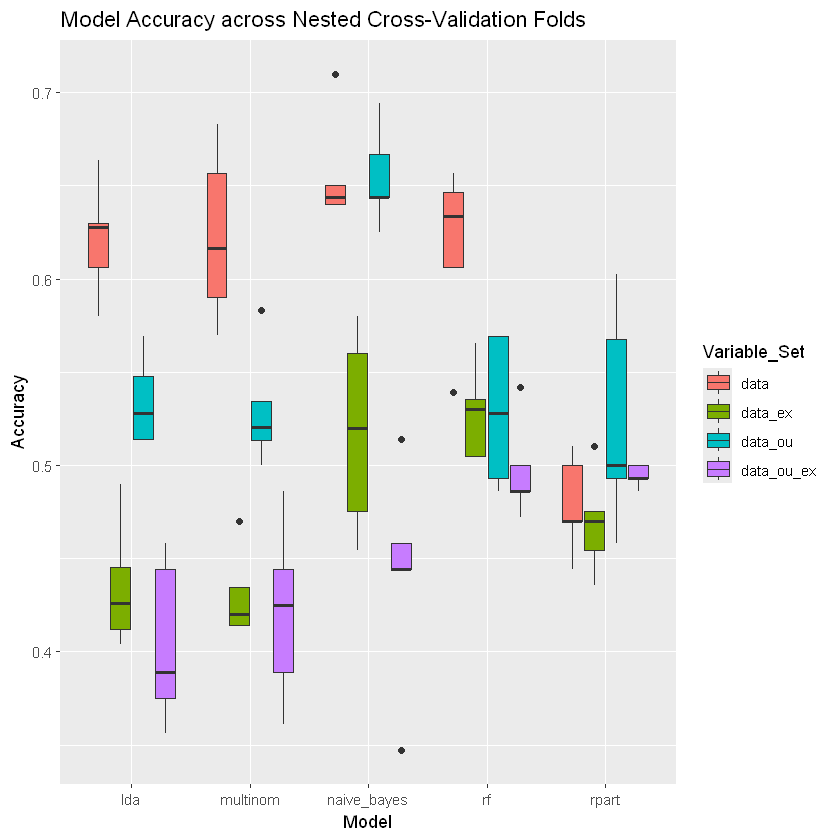

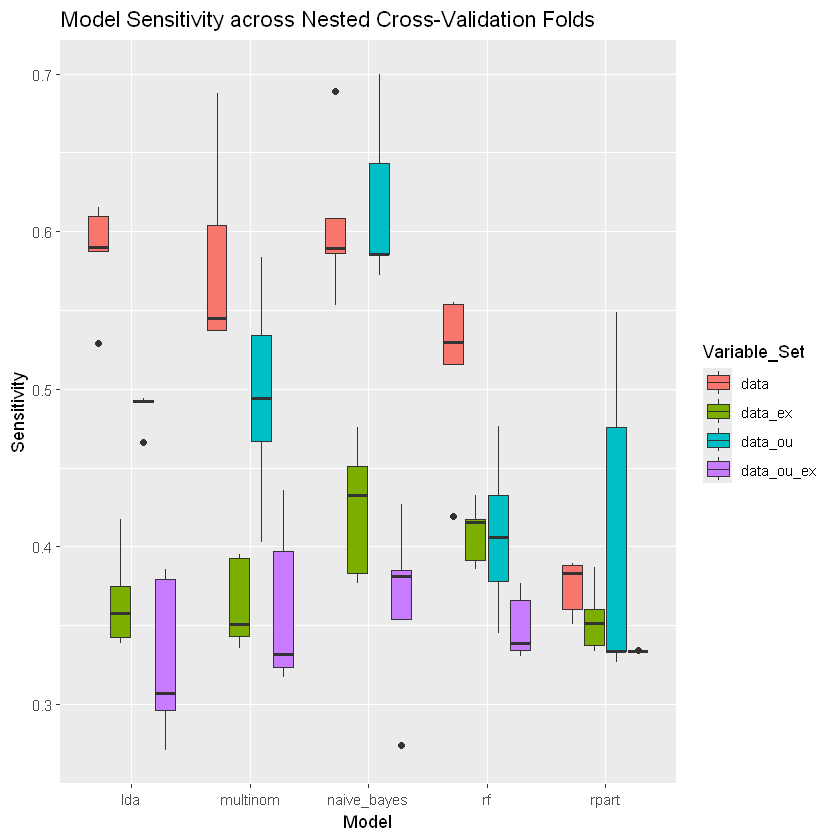

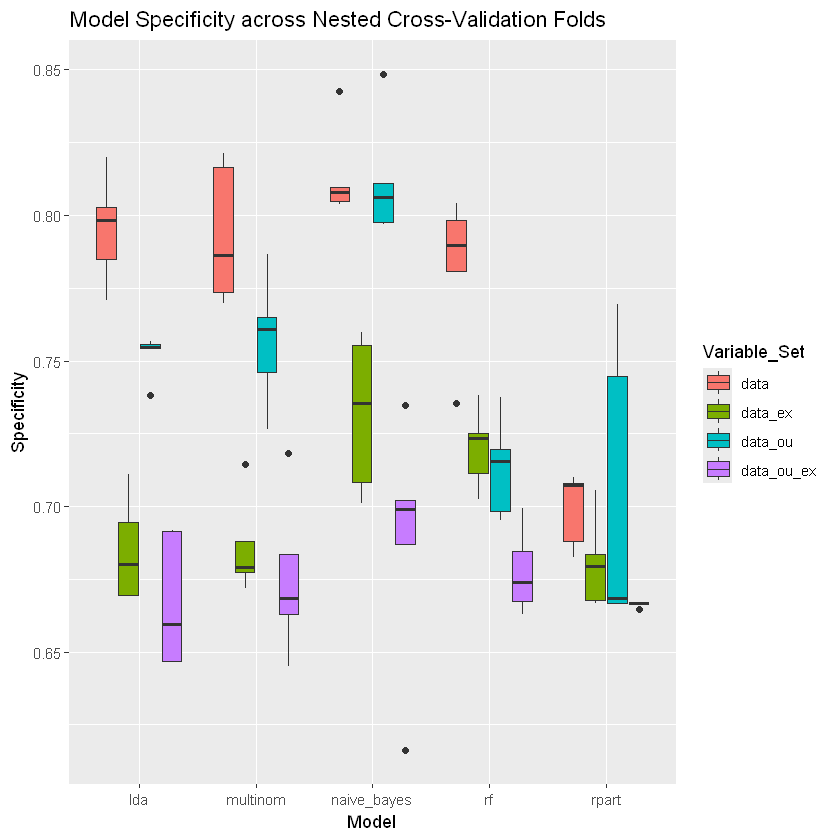

In [ ]:
# Define outer and inner folds
outer_folds <- 5
inner_folds <- 3

classification_methods <- c("multinom", "naive_bayes", "lda", "rpart", "rf")

evaluate_model <- function(model, test_data, true_labels) {
  predictions <- predict(model, newdata = test_data)
  
  levels <- levels(true_labels)
  metrics <- multiClassSummary(data.frame(pred = predictions, obs = true_labels), lev = levels)
  
  return(list(
    Accuracy = metrics["Accuracy"],
    Sensitivity = metrics["Mean_Sensitivity"],
    Specificity = metrics["Mean_Specificity"]
  ))
}

# Function to apply sampling techniques
sample_data <- function(data, method = "none") {
  if (method == "smote") {
    data_balanced <- SmoteClassif(y ~ ., dat = data, C.perc = "balance")
  } else if (method == "up") {
    data_balanced <- RandOverClassif(y ~ ., dat = data, C.perc = "balance")
  } else if (method == "down") {
    data_balanced <- RandUnderClassif(y ~ ., dat = data, C.perc = "balance")
  } else {
    # No sampling
    data_balanced <- data
  }
  return(data_balanced)
}

sampling_methods <- c("none", "up", "down", "smote") # Add your sampling methods here

results <- data.frame(Model = character(), Variable_Set = character(), Sampling_Method = character(), Fold = integer(),
                      Accuracy = numeric(), Sensitivity = numeric(), Specificity = numeric(), F1 = numeric(), row.names = NULL)

for (method in classification_methods) {
  for (variable_set in c("data", "data_ex", "data_ou", "data_ou_ex")) {
    
    data_set <- switch(variable_set,
                       "data" = data,
                       "data_ex" = data_excluded,
                       "data_ou" = data_outlier,
                       "data_ou_ex" = data_outlier_excluded)
    
    for (sampling_method in sampling_methods) {
      sampled_data_set <- sample_data(data_set, method = sampling_method)
      
      for (outer_fold in 1:outer_folds) {
        outer_train_index <- createFolds(sampled_data_set$y, k = outer_folds, list = TRUE, returnTrain = TRUE)[[outer_fold]]
        outer_train_data <- sampled_data_set[outer_train_index, ]
        outer_test_data <- sampled_data_set[-outer_train_index, ]
        
        best_inner_model <- NULL
        best_inner_accuracy <- 0
        
        for (inner_fold in 1:inner_folds) {
          inner_train_index <- createFolds(outer_train_data$y, k = inner_folds, list = TRUE, returnTrain = TRUE)[[inner_fold]]
          inner_train_data <- outer_train_data[inner_train_index, ]
          inner_val_data <- outer_train_data[-inner_train_index, ]
          
          model <- train(y ~ ., data = inner_train_data, method = method, trControl = trainControl(method = "cv", number = inner_folds), metric = "Accuracy")
          
          val_pred <- predict(model, newdata = inner_val_data)
          val_accuracy <- mean(val_pred == inner_val_data$y)
          
          if (val_accuracy > best_inner_accuracy) {
            best_inner_model <- model
            best_inner_accuracy <- val_accuracy
          }
        }
        
        outer_metrics <- evaluate_model(best_inner_model, outer_test_data, outer_test_data$y)
        
        results <- rbind(results, data.frame(Model = method, Variable_Set = variable_set, Sampling_Method = sampling_method, Fold = outer_fold,
                                             Accuracy = outer_metrics$Accuracy,
                                             Sensitivity = outer_metrics$Sensitivity,
                                             Specificity = outer_metrics$Specificity, row.names = NULL))
      }
    }
  }
}

# Plot results
ggplot(results, aes(x = Model, y = Accuracy, fill = Variable_Set)) +
  geom_boxplot() +
  facet_wrap(~ Sampling_Method) +
  labs(title = "Model Accuracy across Nested Cross-Validation Folds",
       x = "Model", y = "Accuracy")

ggplot(results, aes(x = Model, y = Sensitivity, fill = Variable_Set)) +
  geom_boxplot() +
  facet_wrap(~ Sampling_Method) +
  labs(title = "Model Sensitivity across Nested Cross-Validation Folds",
       x = "Model", y = "Sensitivity")

ggplot(results, aes(x = Model, y = Specificity, fill = Variable_Set)) +
  geom_boxplot() +
  facet_wrap(~ Sampling_Method) +
  labs(title = "Model Specificity across Nested Cross-Validation Folds",
       x = "Model", y = "Specificity")


In [7]:
# Function to apply sampling techniques
sample_data <- function(data, method = "none") {
  if (method == "smote") {
    data_balanced <- SmoteClassif(y ~ ., dat = data, C.perc = "balance")
  } else if (method == "up") {
    data_balanced <- RandOverClassif(y ~ ., dat = data, C.perc = "balance")
  } else if (method == "down") {
    data_balanced <- RandUnderClassif(y ~ ., dat = data, C.perc = "balance")
  } else {
    # No sampling
    data_balanced <- data
  }
  return(data_balanced)
}

sampling_methods <- c("none", "up", "down", "smote") # Add your sampling methods here

for (sampling_method in sampling_methods) {
  sampled_data_set <- sample_data(data_excluded, method = sampling_method)
  print("Sampling method")
  print(sampling_method)
  print("Sampled data")
  print(head(sampled_data_set))
  print(table(sampled_data_set$y))
}

# # Define outer and inner folds
# outer_folds <- 5
# inner_folds <- 3
# sampling_methods <- c("none", "up", "down", "smote") # Add your sampling methods here
# classification_methods <- c("lda")

# # Initialize results DataFrame
# results <- data.frame(Model = character(), Variable_Set = character(), Sampling_Method = character(), 
#                       Fold = integer(), Accuracy = numeric(), Sensitivity = numeric(), 
#                       Specificity = numeric(), F1 = numeric(), row.names = NULL)

# for (method in classification_methods) {
#   for (variable_set in c("data", "data_ex", "data_ou", "data_ou_ex")) {
    
#     data_set <- switch(variable_set,
#                        "data" = data,
#                        "data_ex" = data_excluded,
#                        "data_ou" = data_outlier,
#                        "data_ou_ex" = data_outlier_excluded)

#     for (sampling_method in sampling_methods) {
#       sampled_data_set <- sample_data(data_set, method = sampling_method)

#       for (outer_fold in 1:outer_folds) {
#         outer_train_index <- createFolds(sampled_data_set$y, k = outer_folds, list = TRUE, returnTrain = TRUE)[[outer_fold]]
#         outer_train_data <- sampled_data_set[outer_train_index, ]
#         outer_test_data <- sampled_data_set[-outer_train_index, ]

#         best_inner_model <- NULL
#         best_inner_accuracy <- 0
        
#         for (inner_fold in 1:inner_folds) {
#           inner_train_index <- createFolds(outer_train_data$y, k = inner_folds, list = TRUE, returnTrain = TRUE)[[inner_fold]]
#           inner_train_data <- outer_train_data[inner_train_index, ]
#           inner_val_data <- outer_train_data[-inner_train_index, ]

#           model <- train(y ~ ., data = inner_train_data, method = method, 
#                          trControl = trainControl(method = "cv", number = inner_folds), metric = "Accuracy")
          
#           val_pred <- predict(model, newdata = inner_val_data)
#           val_accuracy <- mean(val_pred == inner_val_data$y)
          
#           if (val_accuracy > best_inner_accuracy) {
#             best_inner_model <- model
#             best_inner_accuracy <- val_accuracy
#           }
#         }
        
#         outer_metrics <- evaluate_model(best_inner_model, outer_test_data, outer_test_data$y)
        
#         results <- rbind(results, data.frame(Model = method, Variable_Set = variable_set, 
#                                              Sampling_Method = sampling_method, Fold = outer_fold,
#                                              Accuracy = outer_metrics$Accuracy,
#                                              Sensitivity = outer_metrics$Sensitivity,
#                                              Specificity = outer_metrics$Specificity, row.names = NULL))
#       }
#     }
#   }
# }

# # Plot results with sampling method
# ggplot(results, aes(x = Sampling_Method, y = Accuracy, fill = Variable_Set)) +
#   geom_boxplot() +
#   labs(title = "Model Accuracy across Nested Cross-Validation Folds by Sampling Method",
#        x = "Sampling Method", y = "Accuracy")

# ggplot(results, aes(x = Sampling_Method, y = Sensitivity, fill = Variable_Set)) +
#   geom_boxplot() +
#   labs(title = "Model Sensitivity across Nested Cross-Validation Folds by Sampling Method",
#        x = "Sampling Method", y = "Sensitivity")

# ggplot(results, aes(x = Sampling_Method, y = Specificity, fill = Variable_Set)) +
#   geom_boxplot() +
#   labs(title = "Model Specificity across Nested Cross-Validation Folds by Sampling Method",
#        x = "Sampling Method", y = "Specificity")


[1] "Sampling method"
[1] "none"
[1] "Sampled data"
          X1           X2         X3         X4          X5         X6
1  0.1520951 -0.001077043  1.3232418  0.4829507  1.18447294  0.3128938
2  1.4828231 -1.320965483  0.8605130 -1.5410116 -1.19194583  1.0559602
3  1.6973454  1.575098487 -0.9227483  0.8383256 -0.71254470 -0.2796727
4 -1.1266522  1.213395380 -1.6323412  1.3704219 -0.77110979  0.5366186
5  0.7427705  0.319138772 -1.4308311 -0.7153544 -1.43298490 -1.2511355
6  1.0272638 -1.549598214 -1.3811201 -0.1612517  0.06608898  0.3763517
          X7         X8         X9        X10         X11        X12
1 -1.0309908 -1.1270022  1.0249860  1.4966017  0.11115773  0.8332604
2 -0.9621786  1.0931273  1.2423460 -0.2570111  0.12281814  0.4889229
3 -0.9251125 -0.5612810 -0.8580621  0.6826289 -1.20773705 -0.8165060
4  1.6303239  0.4889026  0.4843326 -1.2531756  0.80254853  1.2836441
5 -0.3360766  0.1892026  1.5472019  0.4840599 -0.03292476 -1.1545984
6  0.7836426  0.3381814 -0.3515586 -0

In [8]:
results %>% arrange(desc(Accuracy))

Model,Variable_Set,Fold,Accuracy,Sensitivity,Specificity
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>
naive_bayes,data,4,0.7100000,0.6887857,0.8426680
naive_bayes,data_ou,2,0.6944444,0.7000495,0.8485850
multinom,data,3,0.6831683,0.6877555,0.8214594
naive_bayes,data_ou,5,0.6666667,0.6435340,0.8108658
lda,data,1,0.6633663,0.6155522,0.8198285
rf,data,4,0.6568627,0.5551074,0.8042795
multinom,data,4,0.6565657,0.6041179,0.8165863
naive_bayes,data,3,0.6500000,0.5860984,0.8095523
rf,data,2,0.6464646,0.5537037,0.7981812


In [ ]:
# Fit the GAM model
data_gam <- data
data_gam[, excluded_vars] <- lapply(data_gam[, excluded_vars], as.factor)
preprocess_params_gam <- preProcess(data_gam[, numeric_vars], method = c("center", "scale"))
data_scaled_gam <- data_gam
data_scaled_gam[, numeric_vars] <- predict(preprocess_params_gam, data_gam[, numeric_vars])
print(head(data_scaled_gam))
continuous_vars <- paste0("s(X", 1:45, ")", collapse = " + ")
categorical_vars <- paste0("X", 46:50, collapse = " + ")
formula_string <- paste("y ~", continuous_vars, "+", categorical_vars)
model_formula <- as.formula(formula_string)
print(model_formula)

          X1           X2         X3         X4          X5         X6
1  0.1520951 -0.001077043  1.3232418  0.4829507  1.18447294  0.3128938
2  1.4828231 -1.320965483  0.8605130 -1.5410116 -1.19194583  1.0559602
3  1.6973454  1.575098487 -0.9227483  0.8383256 -0.71254470 -0.2796727
4 -1.1266522  1.213395380 -1.6323412  1.3704219 -0.77110979  0.5366186
5  0.7427705  0.319138772 -1.4308311 -0.7153544 -1.43298490 -1.2511355
6  1.0272638 -1.549598214 -1.3811201 -0.1612517  0.06608898  0.3763517
          X7         X8         X9        X10         X11        X12
1 -1.0309908 -1.1270022  1.0249860  1.4966017  0.11115773  0.8332604
2 -0.9621786  1.0931273  1.2423460 -0.2570111  0.12281814  0.4889229
3 -0.9251125 -0.5612810 -0.8580621  0.6826289 -1.20773705 -0.8165060
4  1.6303239  0.4889026  0.4843326 -1.2531756  0.80254853  1.2836441
5 -0.3360766  0.1892026  1.5472019  0.4840599 -0.03292476 -1.1545984
6  0.7836426  0.3381814 -0.3515586 -0.3020698 -0.33811617  0.8372291
          X13       

In [ ]:
# Define outer and inner folds
outer_folds <- 5
inner_folds <- 3

evaluate_gam_model <- function(model, test_data, true_labels) {
    predictions <- predict(model, newdata = test_data, type = "response")
    predicted_classes <- apply(predictions, 1, which.max)
    levels <- levels(true_labels)
    predicted_classes <- levels[predicted_classes]
    
    accuracy <- mean(predicted_classes == true_labels)
    return(accuracy)
}

results_gam <- data.frame(Fold = integer(), Accuracy = numeric(), row.names = NULL)

for (outer_fold in 1:outer_folds) {
    outer_train_index <- createFolds(data_scaled_gam$y, k = outer_folds, list = TRUE, returnTrain = TRUE)[[outer_fold]]
    outer_train_data <- data_scaled_gam[outer_train_index, ]
    outer_test_data <- data_scaled_gam[-outer_train_index, ]
    
    best_inner_model <- NULL
    best_inner_accuracy <- 0
    
    for (inner_fold in 1:inner_folds) {
        inner_train_index <- createFolds(outer_train_data$y, k = inner_folds, list = TRUE, returnTrain = TRUE)[[inner_fold]]
        inner_train_data <- outer_train_data[inner_train_index, ]
        inner_val_data <- outer_train_data[-inner_train_index, ]
        
        gam_model <- gam(model_formula, family = multinom(K = 3), data = inner_train_data)
        
        val_accuracy <- evaluate_gam_model(gam_model, inner_val_data, inner_val_data$y)
        
        if (val_accuracy > best_inner_accuracy) {
            best_inner_model <- gam_model
            best_inner_accuracy <- val_accuracy
        }
    }
    
    outer_accuracy <- evaluate_gam_model(best_inner_model, outer_test_data, outer_test_data$y)
    
    results_gam <- rbind(results_gam, data.frame(Fold = outer_fold, Accuracy = outer_accuracy, row.names = NULL))
}

row.names(results_gam) <- NULL


# Plot results
ggplot(results_gam, aes(x = factor(Fold), y = Accuracy)) +
    geom_boxplot() +
    labs(title = "GAM Model Accuracy across Nested Cross-Validation Folds",
         x = "Fold", y = "Accuracy")


ERROR: Error in offset[[i]]: tentative de sélection de moins d'un élément dans integerOneIndex
